In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
'''
# install required system dependencies
!apt-get install -y xvfb x11-utils
# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
!pip install pyvirtualdisplay==0.2.*
'''

'\n# install required system dependencies\n!apt-get install -y xvfb x11-utils\n# install required python dependencies (might need to install additional gym extras depending)\n!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*\n!pip install pyvirtualdisplay==0.2.*\n'

In [3]:
''' Installing cuda without openGL on Debian 9 stretch. Basically Xvfb doesn't play nice with Nvidia's openGL installation, 
so you have to install it with --no-opengl-libs flags. First, just use the driver recommended at the start up screen of controlla-1-image 
with --no-opengl-libs flag added
    a. Follow unbuntu 16.04 (https://developer.nvidia.com/cuda-10.0-download-archive target_os=Linux&target_arch=x86_64&target_distro=Ubuntu&target_version=1604&target_type=runfilelocal)
        1. wget https://developer.nvidia.com/compute/cuda/10.0/Prod/local_installers/cuda_10.0.130_410.48_linux.run
        2. sudo sh cuda_10.0.130_410.48_linux.run --no-opengl-libs
    b. Adapt script from https://gist.github.com/8enmann/931ec2a9dc45fde871d2139a7d1f2d78 to remove old install
        1. sudo apt-get --purge remove nvidia-*
        2. sudo nvidia-uninstall
    c. Please make sure that PATH contains /usr/local/cuda/bin and LD_LIBRARY_PATH contains /usr/local/cuda/lib64
        1.   export PATH=$PATH:/usr/local/cuda-10.0/bin
        2.   export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda-10.0/lib64
    d. Extra things needed to be moved to the right dirs (https://docs.nvidia.com/deeplearning/cudnn/install-guide/index.html section 2.3 to get tar file for Nvidia toolkit)
        1. sudo cp cuda/include/cudnn*.h /usr/local/cuda/include 
        2. sudo cp -P cuda/lib64/libcudnn* /usr/local/cuda/lib64 
        3. sudo chmod a+r /usr/local/cuda/include/cudnn*.h /usr/local/cuda/lib64/libcudnn*
'''

" Installing cuda without openGL on Debian 9 stretch. Basically Xvfb doesn't play nice with Nvidia's openGL installation, \nso you have to install it with --no-opengl-libs flags. First, just use the driver recommended at the start up screen of controlla-1-image \nwith --no-opengl-libs flag added\n    a. Follow unbuntu 16.04 (https://developer.nvidia.com/cuda-10.0-download-archive target_os=Linux&target_arch=x86_64&target_distro=Ubuntu&target_version=1604&target_type=runfilelocal)\n        1. wget https://developer.nvidia.com/compute/cuda/10.0/Prod/local_installers/cuda_10.0.130_410.48_linux.run\n        2. sudo sh cuda_10.0.130_410.48_linux.run --no-opengl-libs\n    b. Adapt script from https://gist.github.com/8enmann/931ec2a9dc45fde871d2139a7d1f2d78 to remove old install\n        1. sudo apt-get --purge remove nvidia-*\n        2. sudo nvidia-uninstall\n    c. Please make sure that PATH contains /usr/local/cuda/bin and LD_LIBRARY_PATH contains /usr/local/cuda/lib64\n        1.   expor

In [4]:
import deluca
import gym
import jax
import jax.numpy as jnp
from deluca.envs import LDS
from deluca.agents import GPC
from pyvirtualdisplay import Display
from tqdm import tqdm

W0324 12:41:29.480148 4383424000 xla_bridge.py:131] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/Users/alexjyu/miniconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time 

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    # plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.title("%s | Step: %d %s" % (type(env).__name__,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    # time.sleep(0.1)
    display.display(plt.gcf())

def smooth_show_state(env, step=0, prev_state=None, info=""):
    new_state = env.state
    dist = ((new_state[1] - prev_state[1])**2 + (new_state[0] - prev_state[0])**2) ** 0.5
    num_steps = max(1, int(dist/0.1)) # enforce num_steps >= 1
    for i in range(1, num_steps + 1):
        intermediate_state = prev_state * float(1 - i/(num_steps)) + new_state * float(i/(num_steps))
        env.state = intermediate_state
        plt.figure(3)
        plt.clf()
        plt.imshow(env.render(mode='rgb_array'))
        # plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
        plt.title("%s | Step: %d %s" % (type(env).__name__,step, info))
        plt.axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())
    # time.sleep(10.0)

In [6]:

def loop(context, i):
    env, controller = context
    A, B, state = env.A, env.B, env.state
    try:
        action = controller(state, A, B)
    except:
        action = controller(state)
    prev_state = env.state
    env.step(action)
    smooth_show_state(env, step=i, prev_state=prev_state)
    # state = A @ state + B @ action + np.random.normal(0, 0.2, size=(n,1)) # gaussian noise

    # if(i % T//2 == 0): # switch system
    #     A,B = jnp.array([[1.,1.5], [0,1.]]), jnp.array([[0],[0.9]])
    error = jnp.linalg.norm(state)+jnp.linalg.norm(action)
    return (env, controller), error

def get_errs(T, controller, A, B):
    # state = jnp.zeros((n, 1))
    env = LDS(state_size=3, action_size=1, A=A, B=B)
    errs = [0.0]
    
    for i in tqdm(range(1, T)):
        (env, controller), error = loop((env, controller), i)
        errs.append(float(error))
    
    return errs



In [7]:
# needed to connect to "fake" monitor (not actually used)
display_dummy = Display(visible=False, size=(1400, 900))
display_dummy.start()

EasyProcessError: start error <EasyProcess cmd_param=['Xvfb', '-help'] cmd=['Xvfb', '-help'] oserror=[Errno 2] No such file or directory: 'Xvfb': 'Xvfb' return_code=None stdout="None" stderr="None" timeout_happened=False>

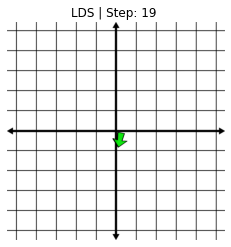

100%|██████████| 19/19 [00:26<00:00,  1.41s/it]


GPC incurs  0.5488632868748458  loss under gaussian iid noise


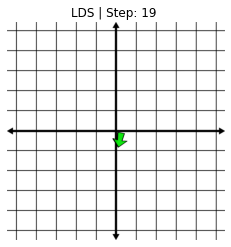

In [8]:
# for loop version
T = 20
A,B = jnp.array([[1.,.5,1.], [0,1.,0.], [0.,0.1,0.]]), jnp.array([[0],[1.2],[0.]])
gpc = GPC(A, B)
gpc_errs = get_errs(T, gpc, A, B)
# print(gpc_errs)
print("GPC incurs ", jnp.mean(jnp.asarray(gpc_errs)), " loss under gaussian iid noise")